In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import hickle
from ase.units import Hartree
from ase.io import read
from ase.visualize import view
import ase

In [2]:
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion
from equistore import operations
from equistore_utils.clebsh_gordan import ClebschGordanReal
from equistore_utils.mp_utils import  *
from equistore_utils.acdc_mini import acdc_standardize_keys
from equistore import Labels, TensorBlock, TensorMap
from itertools import product
import torch

In [3]:
hypers = {
    "cutoff": 2.0,
    "max_radial": 6,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
cg = ClebschGordanReal(6)

calculator = SphericalExpansion(**hypers)

def compute_rho3(frames):
    rhoi = calculator.compute(frames)
    rhoi = rhoi.keys_to_properties(['species_neighbor'])
    rho1i = acdc_standardize_keys(rhoi)
    # selects only one environment
    rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
    rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
    rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])
    
    raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    ])
#     print(raw.shape)
#     hickle.dump (raw, feat_file+ 'feat_123.hickle')
#     feats = PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) 
#     hickle.dump(feats, feat_file + 'feat_123_PCA.hickle')
    
    return raw

def compute_3c(frames):
    calculator = SphericalExpansion(**hypers)
    rhoi = calculator.compute(frames)
    rhoi = rhoi.keys_to_properties(['species_neighbor'])
    rho1i = acdc_standardize_keys(rhoi)

    # selects only one environment
    rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )

    calculator = PairExpansion(**hypers)
    gij = calculator.compute(frames)
    gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
    gij =  acdc_standardize_keys(gij)


    rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)
    rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)
    raw = np.hstack([rhoii1i2_nu1.block(0).values.squeeze(),rhoii1i2_nu1.block(1).values.squeeze()])
    #print(raw.shape)
    # feats_n2nu1 = PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw)
    #hickle.dump(feats_n2nu1, feat_file+'feat_3cnu1_PCA.hickle')

    return raw, rhoii1i2_nu1

# REVISION 

In [4]:
import sys 
sys.path.insert(1, '/Users/jigyasa/scratch/bispectrum_counter/boron/')
from autoencoder_feat import BlockEncoderDecoder

In [5]:
np.random.seed(687074)

In [6]:
noise = np.random.normal(0,1,(2,8,3))
scale_factor1 = 1e-2
#bispectrum vs deepset features using a cloud of structures close to the degenerate manifold

In [7]:
frames = read('/Users/jigyasa/scratch/bispectrum_counter/boron/boron_8000_pbeccpvdz.xyz',':')

In [8]:
def distort_coords(frames, noise_mean = 0, noise_var = 1, scale_factor=1e-2, symmetric = True):
    """Distort the pair of coordinates with a Gaussian Noise with 
    :param:
        noise_var (float): variance of the Gaussian distribution to sample noise N(0, sigma = noise_var)
        scale_factor (float) : multiplicative factor to multiply the noise before corrupting coordinates
        symmetric (bool) : The degenerate pair perturbed by the same noise
        
    Values used for further experiments: 
    noise_mean = 0, scale_factor =1e-2
    """
    
    coords = np.asarray([f.positions for f in frames ])
    distorted_coords = []
    distorted_frames = []
    noise_per_pair = []

    for i in range(0,len(frames),2):
        for xx in range(25000):
            if symmetric: 
                noise = np.random.normal(0,noise_var,(8,3))*scale_factor
            else: 
                noise = np.random.normal(0,noise_var,(2,8,3))*scale_factor
            d1, d2 = coords[i:i+2]+noise
            f1 = ase.Atoms(frames[i].symbols, positions = d1, pbc=False)
            f2 = ase.Atoms(frames[i].symbols, positions = d2, pbc= False)
    #         distorted_coords.append(coords[i:i+2]+noise)
            dist1 = f1.get_all_distances()
            dist2 = f2.get_all_distances()
            if (dist1[0,1:].min()>1.5 and dist1[0,1:].max()<1.85 and dist1[np.triu_indices(len(dist1),1)].flatten().min()>1.2)and (dist2[0,1:].min()>1.5 and dist2[0,1:].max()<1.8 and dist2[np.triu_indices(len(dist2),1)].flatten().min()>1.2):
                distorted_frames.append(f1)
                distorted_frames.append(f2)
                noise_per_pair.append(noise)
                break 
        if (xx>24990):
            print(i, "oops!") 
            print(dist1[0,1:].min(), dist1[0,1:].max(), dist1[np.triu_indices(len(dist1),1)].flatten().min())
            print(dist2[0,1:].min(), dist2[0,1:].max(), dist2[np.triu_indices(len(dist2),1)].flatten().min())

    return distorted_frames, noise_per_pair
    # distort_dist = []
# for i in range(0,8000):
#     distort_dist.append(np.linalg.norm(coords[i] - distorted_coords[i] ))

In [9]:
distorted_frames_a, noise_a= distort_coords(frames, noise_var=1e-7)
distorted_frames_b, noise_b= distort_coords(frames, noise_var=1e-6)
distorted_frames_c, noise_c= distort_coords(frames, noise_var=1e-4)
distorted_frames_d, noise_d= distort_coords(frames, noise_var=1e-2)
distorted_frames_e, noise_e= distort_coords(frames, noise_var=1e-1)
distorted_frames_f, noise_f= distort_coords(frames, noise_var=1)

In [12]:
#run this cell 4 times 
asy_distorted_frames_a, asy_noise_a= distort_coords(frames, noise_var=1e-7, symmetric=False)
print("done")
asy_distorted_frames_b, asy_noise_b= distort_coords(frames, noise_var=1e-6, symmetric=False)
print("done")
asy_distorted_frames_c, asy_noise_c= distort_coords(frames, noise_var=1e-4, symmetric=False)
print("done")
asy_distorted_frames_d, asy_noise_d= distort_coords(frames, noise_var=1e-2, symmetric=False)
print("done")
asy_distorted_frames_e, asy_noise_e= distort_coords(frames, noise_var=1e-1, symmetric=False)
# print("done")
# asy_distorted_frames_f, asy_noise_f= distort_coords(frames, noise_var=1, symmetric=False)

done
done
done
done


In [15]:
# from ase.io import write
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-7.xyz',distorted_frames_a )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-6.xyz',distorted_frames_b )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-4.xyz',distorted_frames_c )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-2.xyz',distorted_frames_d )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-1.xyz',distorted_frames_e )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1.xyz',distorted_frames_f )

# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-7.xyz',asy_distorted_frames_a )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-6.xyz',asy_distorted_frames_b )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-4.xyz',asy_distorted_frames_c )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-2.xyz',asy_distorted_frames_d )
# write('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-1.xyz',asy_distorted_frames_e )

# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/noise_var1e-7.xyz', noise_a)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/noise_var1e-6.xyz', noise_b)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/noise_var1e-4.xyz', noise_c)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/noise_var1e-2.xyz', noise_d)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/noise_var1e-1.xyz', noise_e)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/noise_var1.xyz', noise_f)

# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/noise_var1e-7.xyz', asy_noise_a)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/noise_var1e-6.xyz', asy_noise_b)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/noise_var1e-4.xyz', asy_noise_c)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/noise_var1e-2.xyz', asy_noise_d)
# np.save('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/noise_var1e-1.xyz', asy_noise_e)



In [179]:
asy_dcoords = np.asarray([f.positions for f in asy_distorted_frames_a])
sy_dcoords = np.asarray([f.positions for f in distorted_frames_a])
coords = np.asarray([f.positions for f in frames])
distort_dist_symmetric = []
distort_dist_asymmetric = []
ff = []
for i in range(len(frames)):
    distort_dist_symmetric.append(np.linalg.norm(coords[i] - sy_dcoords[i] ))
    distort_dist_asymmetric.append(np.linalg.norm(coords[i] - asy_dcoords[i] ))

In [ ]:
## load frames

In [8]:
distorted_frames_a = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-7.xyz',":")
distorted_frames_b = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-6.xyz',":")
distorted_frames_c = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-4.xyz',":")
distorted_frames_d = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-2.xyz',":")
distorted_frames_e = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-1.xyz',":")
distorted_frames_f = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e.xyz',":")



In [9]:
NFRAME = 200

In [18]:
rho3i_a = compute_rho3(distorted_frames_a[:NFRAME])
feat_3c_a, rhoii1i2_nu1_a = compute_3c(distorted_frames_a[:NFRAME])
print('a done')

a done


In [104]:
triple_sample_array = rhoii1i2_nu1_a.block(0).samples.asarray()#.values#np.load(feat_file + 'triple_samples.npy')
triple_sample_names = rhoii1i2_nu1_a.block(0).samples.names #np.load(feat_file + 'triple_samples_names.npy')
triple_samples = rhoii1i2_nu1_a.block(0).samples #Labels(list(triple_sample_names), triple_sample_array)
#
#feats_nu_to7 = hickle.load(feat_file + 'feat_1234567_PCA.hickle') # 'feat_1234567_parity1_PCA.hickle'
#feats_nu_to7 = torch.tensor(feats_nu_to7, device=device)
#feats_n2nu1 = hickle.load(feat_file+ 'feat_3cnu1_PCA.hickle' )
#feats_n2nu1 = torch.tensor(feats_n2nu1, device=device)
#
targets = torch.zeros((50,3))
input_size = torch.tensor(feat_3c_a).shape[-1]
hidden_size = 512 
intermediate_size = 128 
encode_type = 'linear'#'nonlinear'
output_size =  8000 #feats_nu_to7.shape[-1]#200

linear_model_block = BlockEncoderDecoder(input_size=input_size, hidden_size=hidden_size,
                                 intermediate_size=intermediate_size, encode_type="linear",
                                 output_size = output_size

                                                 )

nonlinear_model_block = BlockEncoderDecoder(input_size=input_size, hidden_size=hidden_size,
                                 intermediate_size=intermediate_size, encode_type="nonlinear",
                                 output_size = output_size

                                                 )

def iterate_minibatches(inputs, outputs, batch_size):
    for index in range(0, int(inputs.shape[0]/64), batch_size):
        yield inputs[index*64 : (index + batch_size)*64], outputs[index : index + batch_size], index
        
BATCH_SIZE = 250

In [114]:
nl_checkpoint = torch.load('/Users/jigyasa/scratch/bispectrum_counter/boron/nl-adam-best_double_silu8k.pt')
lin_checkpoint = torch.load('/Users/jigyasa/scratch/bispectrum_counter/boron/lin-adam-best_double_silu8k.pt')
lepoch_load = lin_checkpoint['epoch']
print(lepoch_load)

nlepoch_load = nl_checkpoint['epoch']
print(nlepoch_load)

linear_model_block.load_state_dict(lin_checkpoint['model_state_dict'])
nonlinear_model_block.load_state_dict(nl_checkpoint['model_state_dict'])
def get_model_predictions(feats_n2nu1, model_block):
    predictions = []
    for feat, target,index in iterate_minibatches(torch.tensor(feats_n2nu1), targets[:, :output_size], BATCH_SIZE):
        tsamples = Labels(triple_sample_names, triple_sample_array[index*64:(index+BATCH_SIZE)*64])
        print(feat.shape)
        struct_feat = model_block.structure_wise_feats(feat, tsamples)
        #         print(index,tsamples)
        #     print(struct_feat)
        predicted = model_block.forward(struct_feat)
        predictions.append(predicted.data.detach().numpy())

    predictions = torch.tensor(np.concatenate(predictions, axis = 0)) 
    return predictions

def get_model_encoded(feats_n2nu1, model_block):
    return model_block.structure_wise_feats(torch.tensor(feats_n2nu1), triple_samples)

12801
7522


In [115]:
def rmsd(x, nfeats = 1):
    return torch.sqrt(torch.mean(torch.sum((x[0::2] - x[1::2])**2, axis=1)/nfeats))

In [116]:
rmsd_rho3_a = rmsd(torch.tensor(rho3i_a))
lin_rmsd_3c_a = rmsd(get_model_predictions(feat_3c_a,linear_model_block ))
lin_encoded_a = get_model_encoded(feat_3c_a,linear_model_block)
lin_rmsd_encoded_a = rmsd(lin_encoded_a)
print(rmsd_rho3_a, lin_rmsd_3c_a, lin_rmsd_encoded_a)

nl_rmsd_3c_a = rmsd(get_model_predictions(feat_3c_a,nonlinear_model_block ))
nl_encoded_a = get_model_encoded(feat_3c_a,nonlinear_model_block)
nl_rmsd_encoded_a = rmsd(nl_encoded_a)
print(rmsd_rho3_a, nl_rmsd_3c_a, nl_rmsd_encoded_a)

torch.Size([12800, 7344])
tensor(2.9792e-09) tensor(1.5499e-07) tensor(3.3965e-08, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(2.9792e-09) tensor(2.8868e-06) tensor(0.0034, grad_fn=<SqrtBackward0>)


In [117]:
rho3i_b = compute_rho3(distorted_frames_b[:NFRAME])
feat_3c_b, rhoii1i2_nu1_b = compute_3c(distorted_frames_b[:NFRAME])
print('b done')

b done


In [118]:
rmsd_rho3_b = rmsd(torch.tensor(rho3i_b))
lin_rmsd_3c_b = rmsd(get_model_predictions(feat_3c_b,linear_model_block))
lin_encoded_b = get_model_encoded(feat_3c_b,linear_model_block)
lin_rmsd_encoded_b = rmsd(lin_encoded_b)
print(rmsd_rho3_b, lin_rmsd_3c_b, lin_rmsd_encoded_b)

nl_rmsd_3c_b = rmsd(get_model_predictions(feat_3c_b,nonlinear_model_block ))
nl_encoded_b = get_model_encoded(feat_3c_b,nonlinear_model_block)
nl_rmsd_encoded_b = rmsd(nl_encoded_b)
print(rmsd_rho3_b, nl_rmsd_3c_b, nl_rmsd_encoded_b)

torch.Size([12800, 7344])
tensor(2.2533e-08) tensor(1.2005e-06) tensor(2.7154e-07, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(2.2533e-08) tensor(2.8870e-06) tensor(0.0034, grad_fn=<SqrtBackward0>)


In [25]:
rho3i_c = compute_rho3(distorted_frames_c[:NFRAME])
feat_3c_c, rhoii1i2_nu1_c = compute_3c(distorted_frames_c[:NFRAME])
print('c done')

c done


In [119]:
rmsd_rho3_c = rmsd(torch.tensor(rho3i_c))
lin_rmsd_3c_c = rmsd(get_model_predictions(feat_3c_c,linear_model_block))
lin_encoded_c = get_model_encoded(feat_3c_c,linear_model_block)
lin_rmsd_encoded_c = rmsd(lin_encoded_c)
print(rmsd_rho3_c, lin_rmsd_3c_c, lin_rmsd_encoded_c)

nl_rmsd_3c_c = rmsd(get_model_predictions(feat_3c_c,nonlinear_model_block ))
nl_encoded_c = get_model_encoded(feat_3c_c,nonlinear_model_block)
nl_rmsd_encoded_c = rmsd(nl_encoded_c)
print(rmsd_rho3_c, nl_rmsd_3c_c, nl_rmsd_encoded_c)

torch.Size([12800, 7344])
tensor(2.2534e-06) tensor(0.0001) tensor(2.6548e-05, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(2.2534e-06) tensor(3.1123e-06) tensor(0.0037, grad_fn=<SqrtBackward0>)


In [27]:
rho3i_d = compute_rho3(distorted_frames_d[:NFRAME])
feat_3c_d, rhoii1i2_nu1_d = compute_3c(distorted_frames_d[:NFRAME])
print('d done')

d done


In [120]:
rmsd_rho3_d = rmsd(torch.tensor(rho3i_d))
lin_rmsd_3c_d = rmsd(get_model_predictions(feat_3c_d,linear_model_block))
lin_encoded_d = get_model_encoded(feat_3c_d,linear_model_block)
lin_rmsd_encoded_d = rmsd(lin_encoded_d)
print(rmsd_rho3_d, lin_rmsd_3c_d, lin_rmsd_encoded_d)

nl_rmsd_3c_d = rmsd(get_model_predictions(feat_3c_d,nonlinear_model_block ))
nl_encoded_d = get_model_encoded(feat_3c_d,nonlinear_model_block)
nl_rmsd_encoded_d = rmsd(nl_encoded_d)
print(rmsd_rho3_d, nl_rmsd_3c_d, nl_rmsd_encoded_d)

torch.Size([12800, 7344])
tensor(0.0002) tensor(0.0126) tensor(0.0029, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(0.0002) tensor(0.0001) tensor(0.1569, grad_fn=<SqrtBackward0>)


In [29]:
rho3i_e = compute_rho3(distorted_frames_e[:NFRAME])
feat_3c_e, rhoii1i2_nu1_e = compute_3c(distorted_frames_e[:NFRAME])

In [121]:
rmsd_rho3_e = rmsd(torch.tensor(rho3i_e))
lin_rmsd_3c_e = rmsd(get_model_predictions(feat_3c_e,linear_model_block))
lin_encoded_e = get_model_encoded(feat_3c_e,linear_model_block)
lin_rmsd_encoded_e = rmsd(lin_encoded_e)
print(rmsd_rho3_e, lin_rmsd_3c_e, lin_rmsd_encoded_e)

nl_rmsd_3c_e = rmsd(get_model_predictions(feat_3c_e,nonlinear_model_block ))
nl_encoded_e = get_model_encoded(feat_3c_e,nonlinear_model_block)
nl_rmsd_encoded_e = rmsd(nl_encoded_e)
print(rmsd_rho3_e, nl_rmsd_3c_e, nl_rmsd_encoded_e)

torch.Size([12800, 7344])
tensor(0.0020) tensor(0.0935) tensor(0.0251, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(0.0020) tensor(0.0012) tensor(1.3654, grad_fn=<SqrtBackward0>)


In [31]:
rho3i_f = compute_rho3(distorted_frames_f[:NFRAME])
feat_3c_f, rhoii1i2_nu1_f = compute_3c(distorted_frames_f[:NFRAME])

In [122]:
rmsd_rho3_f = rmsd(torch.tensor(rho3i_f))
lin_rmsd_3c_f = rmsd(get_model_predictions(feat_3c_f,linear_model_block))
lin_encoded_f = get_model_encoded(feat_3c_f,linear_model_block)
lin_rmsd_encoded_f = rmsd(lin_encoded_f)
print(rmsd_rho3_f, lin_rmsd_3c_f, lin_rmsd_encoded_f)

nl_rmsd_3c_f = rmsd(get_model_predictions(feat_3c_f,nonlinear_model_block ))
nl_encoded_f = get_model_encoded(feat_3c_f,nonlinear_model_block)
nl_rmsd_encoded_f = rmsd(nl_encoded_f)
print(rmsd_rho3_f, nl_rmsd_3c_f, nl_rmsd_encoded_f)

torch.Size([12800, 7344])
tensor(0.0203) tensor(0.8990) tensor(0.2403, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(0.0203) tensor(0.0121) tensor(14.4523, grad_fn=<SqrtBackward0>)


In [124]:
npair = 100 # number of pairs

variance = [1e-7, 1e-6, 1e-4, 1e-2, 1e-1, 1]

dist_rho3_str = {str(i): np.zeros(npair) for i in variance }
dist_3c_str = {str(i): np.zeros(npair) for i in variance}
lin_dist_encoded_str = {str(i): np.zeros(npair) for i in variance}
nl_dist_encoded_str = {str(i): np.zeros(npair) for i in variance}


j=0
for i in range(0, npair):
    dist_rho3_str[str(1e-7)][i] = np.linalg.norm(rho3i_a[j]-rho3i_a[j+1])
    dist_3c_str[str(1e-7)][i] = np.linalg.norm(feat_3c_a[j]-feat_3c_a[j+1])
    lin_dist_encoded_str[str(1e-7)][i] = torch.linalg.norm(lin_encoded_a[j]-lin_encoded_a[j+1])
    nl_dist_encoded_str[str(1e-7)][i] = torch.linalg.norm(nl_encoded_a[j]-nl_encoded_a[j+1])
    
    dist_rho3_str[str(1e-6)][i] = np.linalg.norm(rho3i_b[j]-rho3i_b[j+1])
    dist_3c_str[str(1e-6)][i] = np.linalg.norm(feat_3c_b[j]-feat_3c_b[j+1])
    lin_dist_encoded_str[str(1e-6)][i] = torch.linalg.norm(lin_encoded_b[j]-lin_encoded_b[j+1])
    nl_dist_encoded_str[str(1e-6)][i] = torch.linalg.norm(nl_encoded_a[j]-nl_encoded_a[j+1])
    
    dist_rho3_str[str(1e-4)][i] = np.linalg.norm(rho3i_c[j]-rho3i_c[j+1])
    dist_3c_str[str(1e-4)][i] = np.linalg.norm(feat_3c_c[j]-feat_3c_c[j+1])
    lin_dist_encoded_str[str(1e-4)][i] = torch.linalg.norm(lin_encoded_c[j]-lin_encoded_c[j+1])
    nl_dist_encoded_str[str(1e-4)][i] = torch.linalg.norm(nl_encoded_c[j]-nl_encoded_c[j+1])
    
    dist_rho3_str[str(1e-2)][i] = np.linalg.norm(rho3i_d[j]-rho3i_d[j+1])
    dist_3c_str[str(1e-2)][i] = np.linalg.norm(feat_3c_d[j]-feat_3c_d[j+1])
    lin_dist_encoded_str[str(1e-2)][i] = torch.linalg.norm(lin_encoded_d[j]-lin_encoded_d[j+1])
    nl_dist_encoded_str[str(1e-2)][i] = torch.linalg.norm(nl_encoded_d[j]-nl_encoded_d[j+1])
    
    dist_rho3_str[str(1e-1)][i] = np.linalg.norm(rho3i_e[j]-rho3i_e[j+1])
    dist_3c_str[str(1e-1)][i] = np.linalg.norm(feat_3c_e[j]-feat_3c_e[j+1])
    lin_dist_encoded_str[str(1e-1)][i] = torch.linalg.norm(lin_encoded_e[j]-lin_encoded_e[j+1])
    nl_dist_encoded_str[str(1e-1)][i] = torch.linalg.norm(nl_encoded_e[j]-nl_encoded_e[j+1])
    
    dist_rho3_str[str(1)][i] = np.linalg.norm(rho3i_f[j]-rho3i_f[j+1])
    dist_3c_str[str(1)][i] = np.linalg.norm(feat_3c_f[j]-feat_3c_f[j+1])
    lin_dist_encoded_str[str(1)][i] = torch.linalg.norm(lin_encoded_f[j]-lin_encoded_f[j+1])
    nl_dist_encoded_str[str(1)][i] = torch.linalg.norm(nl_encoded_f[j]-nl_encoded_f[j+1])
    
    j+=2
 

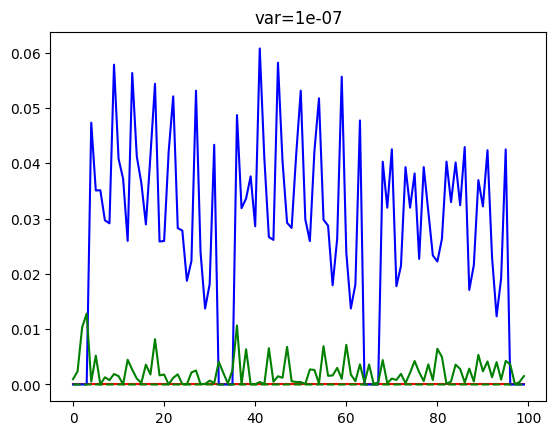

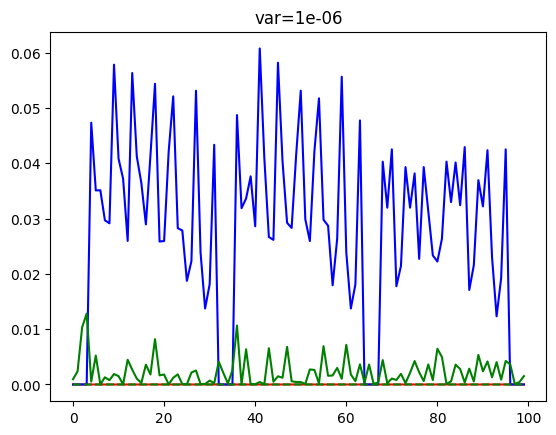

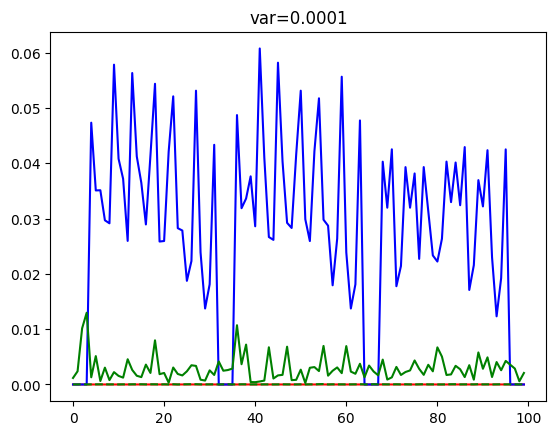

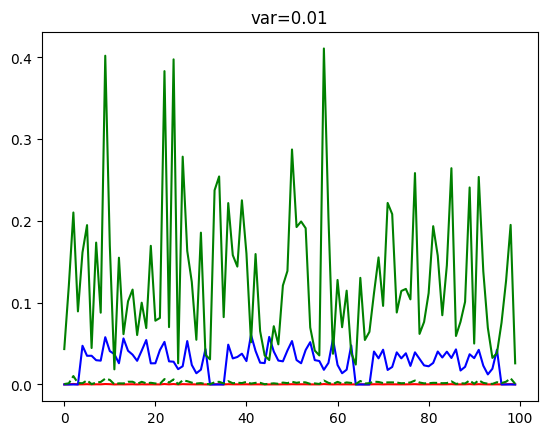

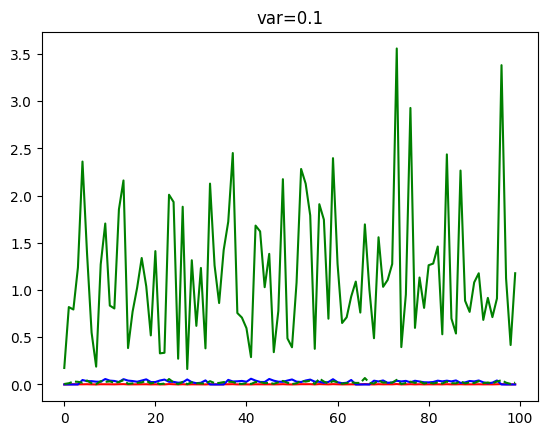

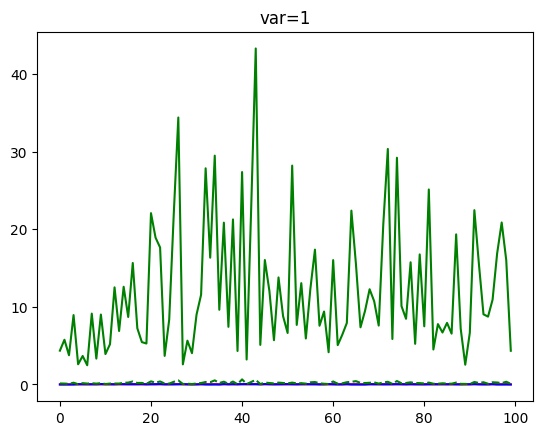

In [126]:
for i in variance:
    plt.figure()
    plt.plot(dist_rho3_str[str(i)], 'r') 
    plt.plot(dist_3c_str[str(i)], 'b')
    plt.plot(lin_dist_encoded_str[str(i)], 'g--')
    plt.plot(nl_dist_encoded_str[str(i)], 'g')
    plt.title("var="+str(i))

(array([46., 22., 12.,  8.,  3.,  5.,  1.,  0.,  2.,  1.]),
 array([3.41698161e-06, 1.28511052e-03, 2.56680407e-03, 3.84849761e-03,
        5.13019115e-03, 6.41188470e-03, 7.69357824e-03, 8.97527178e-03,
        1.02569653e-02, 1.15386589e-02, 1.28203524e-02]),
 <BarContainer object of 10 artists>)

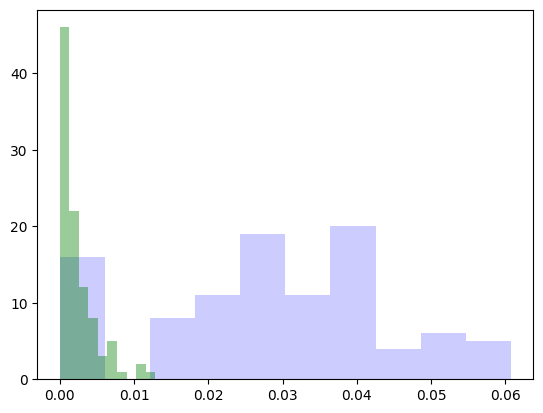

In [86]:
for i in variance:
    plt.figure()
    plt.hist(dist_rho3, color='r', alpha=1)
    plt.hist(dist_3c, color='b', alpha=0.2)
    plt.hist(dist_encoded, color='g',alpha=0.4)

In [127]:
dist_rho3 =[]
dist_3c =[]
lin_dist_encoded = []
nl_dist_encoded = []

dist_rho3.append(np.linalg.norm(rho3i_a[0::2] - rho3i_a[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_b[0::2] - rho3i_b[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_c[0::2] - rho3i_c[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_d[0::2] - rho3i_d[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_e[0::2] - rho3i_e[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_f[0::2] - rho3i_f[1::2]))

In [128]:
dist_3c.append(np.linalg.norm(feat_3c_a[0::2] - feat_3c_a[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_b[0::2] - feat_3c_b[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_c[0::2] - feat_3c_c[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_d[0::2] - feat_3c_d[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_e[0::2] - feat_3c_e[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_f[0::2] - feat_3c_f[1::2]))

In [129]:
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_a[0::2] - lin_encoded_a[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_b[0::2] - lin_encoded_b[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_c[0::2] - lin_encoded_c[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_d[0::2] - lin_encoded_d[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_e[0::2] - lin_encoded_e[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_f[0::2] - lin_encoded_f[1::2]).detach().numpy())

In [131]:
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_a[0::2] - nl_encoded_a[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_b[0::2] - nl_encoded_b[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_c[0::2] - nl_encoded_c[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_d[0::2] - nl_encoded_d[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_e[0::2] - nl_encoded_e[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_f[0::2] - nl_encoded_f[1::2]).detach().numpy())

In [132]:
rmsd_rho3 =[]
rmsd_3c =[]
lin_rmsd_encoded = []
nl_rmsd_encoded = []

rmsd_rho3.append(rmsd(torch.tensor(rho3i_a)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_b)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_c)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_d)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_e)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_f)).detach().numpy())

In [133]:
rmsd_3c.append(rmsd(torch.tensor(feat_3c_a)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_b)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_c)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_d)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_e)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_f)).detach().numpy())

In [134]:
lin_rmsd_encoded.append(rmsd(lin_encoded_a).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_b).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_c).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_d).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_e).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_f).detach().numpy())

In [137]:
nl_rmsd_encoded.append(rmsd(nl_encoded_a).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_b).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_c).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_d).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_e).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_f).detach().numpy())

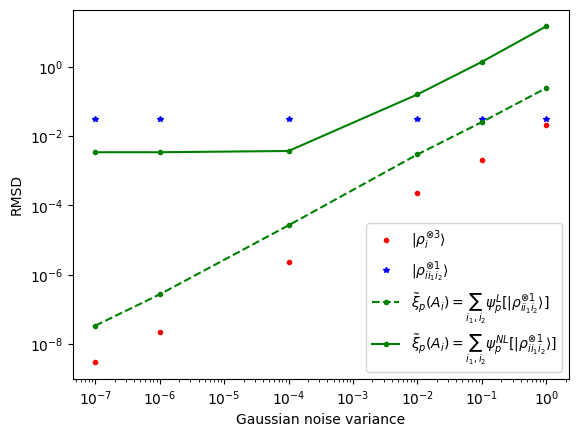

In [141]:
plt.loglog(variance, rmsd_rho3, 'r', ls="", marker="o", markersize=3, label =r"$|\rho_i^{\otimes{3}}\rangle$" )
plt.loglog(variance, rmsd_3c, 'b', ls="", marker="*", markersize=4, label = r"$|\rho_{ii_1 i_2}^{\otimes{1}}\rangle$")
plt.loglog(variance, lin_rmsd_encoded, 'g.', ls = '--', label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p^L[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$")
plt.loglog(variance, nl_rmsd_encoded, 'g.', ls = '-', label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p^{NL}[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$")
plt.xlabel("Gaussian noise variance")
plt.ylabel("RMSD")
plt.legend()
# plt.title("Linear encoder")



## RANDOM NOISE 

In [11]:
asy_distorted_frames_a = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-7.xyz',":")
asy_distorted_frames_b = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-6.xyz',":")
asy_distorted_frames_c = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-4.xyz',":")
asy_distorted_frames_d = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-2.xyz',":")
asy_distorted_frames_e = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-1.xyz',":")

In [142]:
NFRAME = 200

In [10]:
rho3i_a = compute_rho3(asy_distorted_frames_a[:NFRAME])
feat_3c_a, rhoii1i2_nu1_a = compute_3c(asy_distorted_frames_a[:NFRAME])
print('a done')

a done


In [12]:
triple_sample_array = rhoii1i2_nu1_a.block(0).samples.asarray()#.values#np.load(feat_file + 'triple_samples.npy')
triple_sample_names = rhoii1i2_nu1_a.block(0).samples.names #np.load(feat_file + 'triple_samples_names.npy')
triple_samples = rhoii1i2_nu1_a.block(0).samples #Labels(list(triple_sample_names), triple_sample_array)
#
#feats_nu_to7 = hickle.load(feat_file + 'feat_1234567_PCA.hickle') # 'feat_1234567_parity1_PCA.hickle'
#feats_nu_to7 = torch.tensor(feats_nu_to7, device=device)
#feats_n2nu1 = hickle.load(feat_file+ 'feat_3cnu1_PCA.hickle' )
#feats_n2nu1 = torch.tensor(feats_n2nu1, device=device)
#
targets = torch.zeros((50,3))
input_size = torch.tensor(feat_3c_a).shape[-1]
hidden_size = 512 
intermediate_size = 128 
encode_type = 'linear'#'nonlinear'
output_size =  8000 #feats_nu_to7.shape[-1]#200

linear_model_block = BlockEncoderDecoder(input_size=input_size, hidden_size=hidden_size,
                                 intermediate_size=intermediate_size, encode_type="linear",
                                 output_size = output_size

                                                 )

nonlinear_model_block = BlockEncoderDecoder(input_size=input_size, hidden_size=hidden_size,
                                 intermediate_size=intermediate_size, encode_type="nonlinear",
                                 output_size = output_size

                                                 )

def iterate_minibatches(inputs, outputs, batch_size):
    for index in range(0, int(inputs.shape[0]/64), batch_size):
        yield inputs[index*64 : (index + batch_size)*64], outputs[index : index + batch_size], index
        
BATCH_SIZE = 250

In [13]:
nl_checkpoint = torch.load('/Users/jigyasa/scratch/bispectrum_counter/boron/nl-adam-best_double_silu8k.pt')
lin_checkpoint = torch.load('/Users/jigyasa/scratch/bispectrum_counter/boron/lin-adam-best_double_silu8k.pt')
lepoch_load = lin_checkpoint['epoch']
print(lepoch_load)

nlepoch_load = nl_checkpoint['epoch']
print(nlepoch_load)

linear_model_block.load_state_dict(lin_checkpoint['model_state_dict'])
nonlinear_model_block.load_state_dict(nl_checkpoint['model_state_dict'])
def get_model_predictions(feats_n2nu1, model_block):
    predictions = []
    for feat, target,index in iterate_minibatches(torch.tensor(feats_n2nu1), targets[:, :output_size], BATCH_SIZE):
        tsamples = Labels(triple_sample_names, triple_sample_array[index*64:(index+BATCH_SIZE)*64])
        print(feat.shape)
        struct_feat = model_block.structure_wise_feats(feat, tsamples)
        #         print(index,tsamples)
        #     print(struct_feat)
        predicted = model_block.forward(struct_feat)
        predictions.append(predicted.data.detach().numpy())

    predictions = torch.tensor(np.concatenate(predictions, axis = 0)) 
    return predictions

def get_model_encoded(feats_n2nu1, model_block):
    return model_block.structure_wise_feats(torch.tensor(feats_n2nu1), triple_samples)

12801
7522


In [14]:
def rmsd(x, nfeats = 1):
    return torch.sqrt(torch.mean(torch.sum((x[0::2] - x[1::2])**2, axis=1)/nfeats))

In [15]:
rmsd_rho3_a = rmsd(torch.tensor(rho3i_a))
lin_rmsd_3c_a = rmsd(get_model_predictions(feat_3c_a,linear_model_block ))
lin_encoded_a = get_model_encoded(feat_3c_a,linear_model_block)
lin_rmsd_encoded_a = rmsd(lin_encoded_a)
print(rmsd_rho3_a, lin_rmsd_3c_a, lin_rmsd_encoded_a)

nl_rmsd_3c_a = rmsd(get_model_predictions(feat_3c_a,nonlinear_model_block ))
nl_encoded_a = get_model_encoded(feat_3c_a,nonlinear_model_block)
nl_rmsd_encoded_a = rmsd(nl_encoded_a)
print(rmsd_rho3_a, nl_rmsd_3c_a, nl_rmsd_encoded_a)

torch.Size([12800, 7344])
tensor(1.5234e-09) tensor(5.8601e-08) tensor(1.5487e-08, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(1.5234e-09) tensor(2.8869e-06) tensor(0.0034, grad_fn=<SqrtBackward0>)


In [16]:
rho3i_b = compute_rho3(asy_distorted_frames_b[:NFRAME])
feat_3c_b, rhoii1i2_nu1_b = compute_3c(asy_distorted_frames_b[:NFRAME])
print('b done')

b done


In [17]:
rmsd_rho3_b = rmsd(torch.tensor(rho3i_b))
lin_rmsd_3c_b = rmsd(get_model_predictions(feat_3c_b,linear_model_block))
lin_encoded_b = get_model_encoded(feat_3c_b,linear_model_block)
lin_rmsd_encoded_b = rmsd(lin_encoded_b)
print(rmsd_rho3_b, lin_rmsd_3c_b, lin_rmsd_encoded_b)

nl_rmsd_3c_b = rmsd(get_model_predictions(feat_3c_b,nonlinear_model_block ))
nl_encoded_b = get_model_encoded(feat_3c_b,nonlinear_model_block)
nl_rmsd_encoded_b = rmsd(nl_encoded_b)
print(rmsd_rho3_b, nl_rmsd_3c_b, nl_rmsd_encoded_b)

torch.Size([12800, 7344])
tensor(3.2818e-08) tensor(1.4918e-06) tensor(4.2412e-07, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(3.2818e-08) tensor(2.8875e-06) tensor(0.0034, grad_fn=<SqrtBackward0>)


In [19]:
rho3i_c = compute_rho3(asy_distorted_frames_c[:NFRAME])
feat_3c_c, rhoii1i2_nu1_c = compute_3c(asy_distorted_frames_c[:NFRAME])
print('c done')

c done


In [20]:
rmsd_rho3_c = rmsd(torch.tensor(rho3i_c))
lin_rmsd_3c_c = rmsd(get_model_predictions(feat_3c_c,linear_model_block))
lin_encoded_c = get_model_encoded(feat_3c_c,linear_model_block)
lin_rmsd_encoded_c = rmsd(lin_encoded_c)
print(rmsd_rho3_c, lin_rmsd_3c_c, lin_rmsd_encoded_c)

nl_rmsd_3c_c = rmsd(get_model_predictions(feat_3c_c,nonlinear_model_block ))
nl_encoded_c = get_model_encoded(feat_3c_c,nonlinear_model_block)
nl_rmsd_encoded_c = rmsd(nl_encoded_c)
print(rmsd_rho3_c, nl_rmsd_3c_c, nl_rmsd_encoded_c)

torch.Size([12800, 7344])
tensor(2.9022e-06) tensor(0.0001) tensor(3.8635e-05, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(2.9022e-06) tensor(3.2610e-06) tensor(0.0039, grad_fn=<SqrtBackward0>)


In [21]:
rho3i_d = compute_rho3(asy_distorted_frames_d[:NFRAME])
feat_3c_d, rhoii1i2_nu1_d = compute_3c(asy_distorted_frames_d[:NFRAME])
print('d done')

d done


In [22]:
rmsd_rho3_d = rmsd(torch.tensor(rho3i_d))
lin_rmsd_3c_d = rmsd(get_model_predictions(feat_3c_d,linear_model_block))
lin_encoded_d = get_model_encoded(feat_3c_d,linear_model_block)
lin_rmsd_encoded_d = rmsd(lin_encoded_d)
print(rmsd_rho3_d, lin_rmsd_3c_d, lin_rmsd_encoded_d)

nl_rmsd_3c_d = rmsd(get_model_predictions(feat_3c_d,nonlinear_model_block ))
nl_encoded_d = get_model_encoded(feat_3c_d,nonlinear_model_block)
nl_rmsd_encoded_d = rmsd(nl_encoded_d)
print(rmsd_rho3_d, nl_rmsd_3c_d, nl_rmsd_encoded_d)

torch.Size([12800, 7344])
tensor(0.0003) tensor(0.0145) tensor(0.0045, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(0.0003) tensor(0.0002) tensor(0.2182, grad_fn=<SqrtBackward0>)


In [23]:
rho3i_e = compute_rho3(asy_distorted_frames_e[:NFRAME])
feat_3c_e, rhoii1i2_nu1_e = compute_3c(asy_distorted_frames_e[:NFRAME])

In [24]:
rmsd_rho3_e = rmsd(torch.tensor(rho3i_e))
lin_rmsd_3c_e = rmsd(get_model_predictions(feat_3c_e,linear_model_block))
lin_encoded_e = get_model_encoded(feat_3c_e,linear_model_block)
lin_rmsd_encoded_e = rmsd(lin_encoded_e)
print(rmsd_rho3_e, lin_rmsd_3c_e, lin_rmsd_encoded_e)

nl_rmsd_3c_e = rmsd(get_model_predictions(feat_3c_e,nonlinear_model_block ))
nl_encoded_e = get_model_encoded(feat_3c_e,nonlinear_model_block)
nl_rmsd_encoded_e = rmsd(nl_encoded_e)
print(rmsd_rho3_e, nl_rmsd_3c_e, nl_rmsd_encoded_e)

torch.Size([12800, 7344])
tensor(0.0032) tensor(0.1250) tensor(0.0403, grad_fn=<SqrtBackward0>)
torch.Size([12800, 7344])
tensor(0.0032) tensor(0.0018) tensor(2.0614, grad_fn=<SqrtBackward0>)


In [26]:
npair = 100 # number of pairs

variance = [1e-7, 1e-6, 1e-4, 1e-2, 1e-1]#, 1]

dist_rho3_str = {str(i): np.zeros(npair) for i in variance }
dist_3c_str = {str(i): np.zeros(npair) for i in variance}
lin_dist_encoded_str = {str(i): np.zeros(npair) for i in variance}
nl_dist_encoded_str = {str(i): np.zeros(npair) for i in variance}


j=0
for i in range(0, npair):
    dist_rho3_str[str(1e-7)][i] = np.linalg.norm(rho3i_a[j]-rho3i_a[j+1])
    dist_3c_str[str(1e-7)][i] = np.linalg.norm(feat_3c_a[j]-feat_3c_a[j+1])
    lin_dist_encoded_str[str(1e-7)][i] = torch.linalg.norm(lin_encoded_a[j]-lin_encoded_a[j+1])
    nl_dist_encoded_str[str(1e-7)][i] = torch.linalg.norm(nl_encoded_a[j]-nl_encoded_a[j+1])
    
    dist_rho3_str[str(1e-6)][i] = np.linalg.norm(rho3i_b[j]-rho3i_b[j+1])
    dist_3c_str[str(1e-6)][i] = np.linalg.norm(feat_3c_b[j]-feat_3c_b[j+1])
    lin_dist_encoded_str[str(1e-6)][i] = torch.linalg.norm(lin_encoded_b[j]-lin_encoded_b[j+1])
    nl_dist_encoded_str[str(1e-6)][i] = torch.linalg.norm(nl_encoded_a[j]-nl_encoded_a[j+1])
    
    dist_rho3_str[str(1e-4)][i] = np.linalg.norm(rho3i_c[j]-rho3i_c[j+1])
    dist_3c_str[str(1e-4)][i] = np.linalg.norm(feat_3c_c[j]-feat_3c_c[j+1])
    lin_dist_encoded_str[str(1e-4)][i] = torch.linalg.norm(lin_encoded_c[j]-lin_encoded_c[j+1])
    nl_dist_encoded_str[str(1e-4)][i] = torch.linalg.norm(nl_encoded_c[j]-nl_encoded_c[j+1])
    
    dist_rho3_str[str(1e-2)][i] = np.linalg.norm(rho3i_d[j]-rho3i_d[j+1])
    dist_3c_str[str(1e-2)][i] = np.linalg.norm(feat_3c_d[j]-feat_3c_d[j+1])
    lin_dist_encoded_str[str(1e-2)][i] = torch.linalg.norm(lin_encoded_d[j]-lin_encoded_d[j+1])
    nl_dist_encoded_str[str(1e-2)][i] = torch.linalg.norm(nl_encoded_d[j]-nl_encoded_d[j+1])
    
    dist_rho3_str[str(1e-1)][i] = np.linalg.norm(rho3i_e[j]-rho3i_e[j+1])
    dist_3c_str[str(1e-1)][i] = np.linalg.norm(feat_3c_e[j]-feat_3c_e[j+1])
    lin_dist_encoded_str[str(1e-1)][i] = torch.linalg.norm(lin_encoded_e[j]-lin_encoded_e[j+1])
    nl_dist_encoded_str[str(1e-1)][i] = torch.linalg.norm(nl_encoded_e[j]-nl_encoded_e[j+1])
    
#     dist_rho3_str[str(1)][i] = np.linalg.norm(rho3i_f[j]-rho3i_f[j+1])
#     dist_3c_str[str(1)][i] = np.linalg.norm(feat_3c_f[j]-feat_3c_f[j+1])
#     lin_dist_encoded_str[str(1)][i] = torch.linalg.norm(lin_encoded_f[j]-lin_encoded_f[j+1])
#     nl_dist_encoded_str[str(1)][i] = torch.linalg.norm(nl_encoded_f[j]-nl_encoded_f[j+1])
    
    j+=2
 

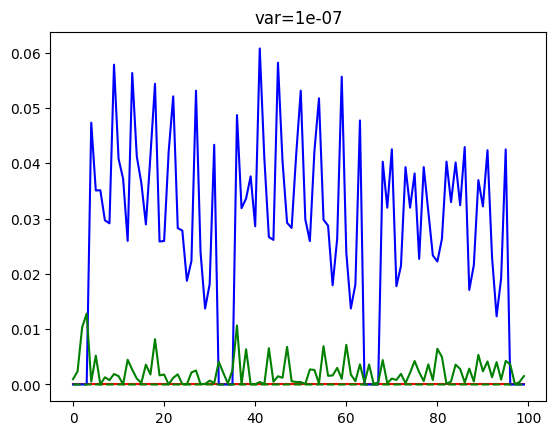

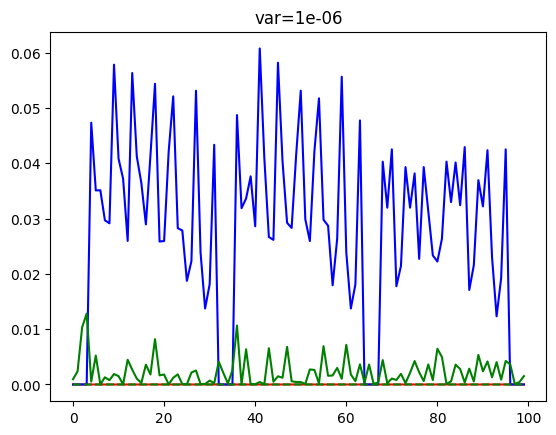

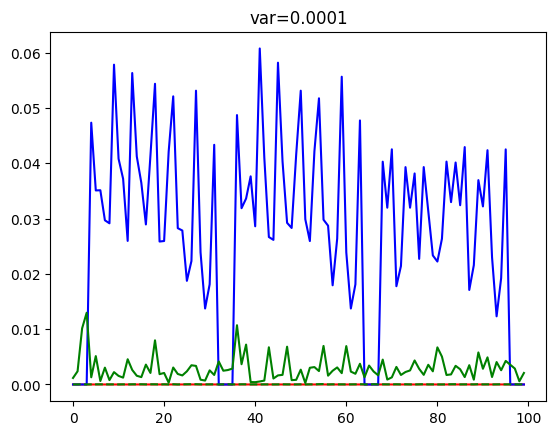

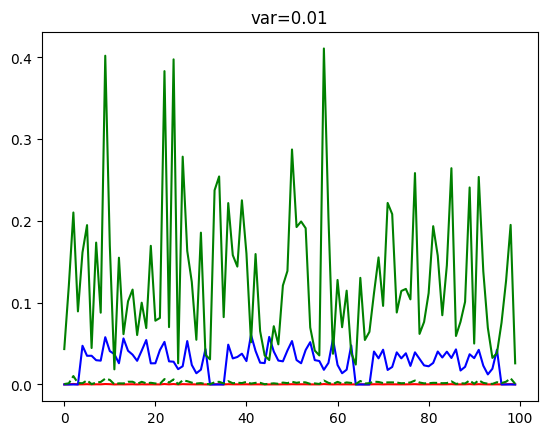

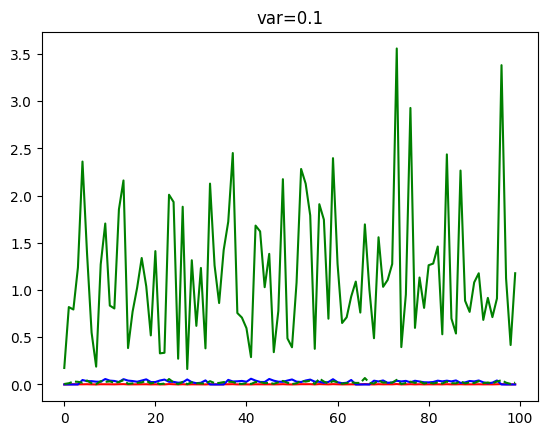

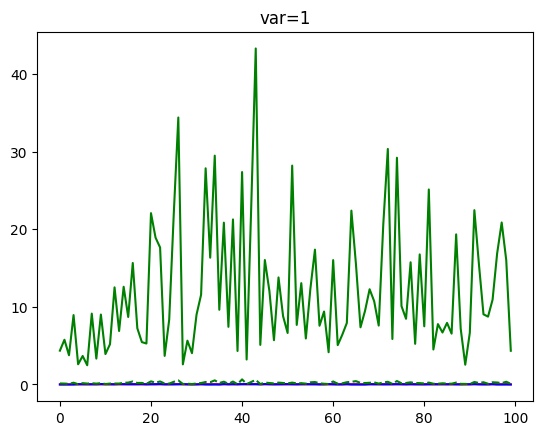

In [126]:
for i in variance:
    plt.figure()
    plt.plot(dist_rho3_str[str(i)], 'r') 
    plt.plot(dist_3c_str[str(i)], 'b')
    plt.plot(lin_dist_encoded_str[str(i)], 'g--')
    plt.plot(nl_dist_encoded_str[str(i)], 'g')
    plt.title("var="+str(i))

(array([46., 22., 12.,  8.,  3.,  5.,  1.,  0.,  2.,  1.]),
 array([3.41698161e-06, 1.28511052e-03, 2.56680407e-03, 3.84849761e-03,
        5.13019115e-03, 6.41188470e-03, 7.69357824e-03, 8.97527178e-03,
        1.02569653e-02, 1.15386589e-02, 1.28203524e-02]),
 <BarContainer object of 10 artists>)

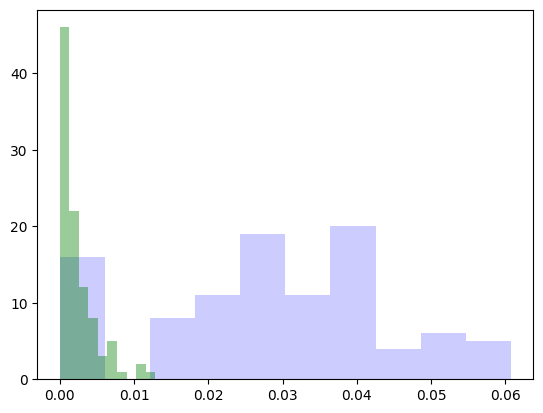

In [86]:
for i in variance:
    plt.figure()
    plt.hist(dist_rho3, color='r', alpha=1)
    plt.hist(dist_3c, color='b', alpha=0.2)
    plt.hist(dist_encoded, color='g',alpha=0.4)

In [127]:
dist_rho3 =[]
dist_3c =[]
lin_dist_encoded = []
nl_dist_encoded = []

dist_rho3.append(np.linalg.norm(rho3i_a[0::2] - rho3i_a[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_b[0::2] - rho3i_b[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_c[0::2] - rho3i_c[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_d[0::2] - rho3i_d[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_e[0::2] - rho3i_e[1::2]))
dist_rho3.append(np.linalg.norm(rho3i_f[0::2] - rho3i_f[1::2]))

In [128]:
dist_3c.append(np.linalg.norm(feat_3c_a[0::2] - feat_3c_a[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_b[0::2] - feat_3c_b[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_c[0::2] - feat_3c_c[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_d[0::2] - feat_3c_d[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_e[0::2] - feat_3c_e[1::2]))
dist_3c.append(np.linalg.norm(feat_3c_f[0::2] - feat_3c_f[1::2]))

In [129]:
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_a[0::2] - lin_encoded_a[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_b[0::2] - lin_encoded_b[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_c[0::2] - lin_encoded_c[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_d[0::2] - lin_encoded_d[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_e[0::2] - lin_encoded_e[1::2]).detach().numpy())
lin_dist_encoded.append(torch.linalg.norm(lin_encoded_f[0::2] - lin_encoded_f[1::2]).detach().numpy())

In [131]:
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_a[0::2] - nl_encoded_a[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_b[0::2] - nl_encoded_b[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_c[0::2] - nl_encoded_c[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_d[0::2] - nl_encoded_d[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_e[0::2] - nl_encoded_e[1::2]).detach().numpy())
nl_dist_encoded.append(torch.linalg.norm(nl_encoded_f[0::2] - nl_encoded_f[1::2]).detach().numpy())

In [27]:
rmsd_rho3 =[]
rmsd_3c =[]
lin_rmsd_encoded = []
nl_rmsd_encoded = []

rmsd_rho3.append(rmsd(torch.tensor(rho3i_a)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_b)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_c)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_d)).detach().numpy())
rmsd_rho3.append(rmsd(torch.tensor(rho3i_e)).detach().numpy())
# rmsd_rho3.append(rmsd(torch.tensor(rho3i_f)).detach().numpy())

In [28]:
rmsd_3c.append(rmsd(torch.tensor(feat_3c_a)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_b)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_c)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_d)).detach().numpy())
rmsd_3c.append(rmsd(torch.tensor(feat_3c_e)).detach().numpy())
# rmsd_3c.append(rmsd(torch.tensor(feat_3c_f)).detach().numpy())

In [29]:
lin_rmsd_encoded.append(rmsd(lin_encoded_a).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_b).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_c).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_d).detach().numpy())
lin_rmsd_encoded.append(rmsd(lin_encoded_e).detach().numpy())
# lin_rmsd_encoded.append(rmsd(lin_encoded_f).detach().numpy())

In [30]:
nl_rmsd_encoded.append(rmsd(nl_encoded_a).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_b).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_c).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_d).detach().numpy())
nl_rmsd_encoded.append(rmsd(nl_encoded_e).detach().numpy())
# nl_rmsd_encoded.append(rmsd(nl_encoded_f).detach().numpy())

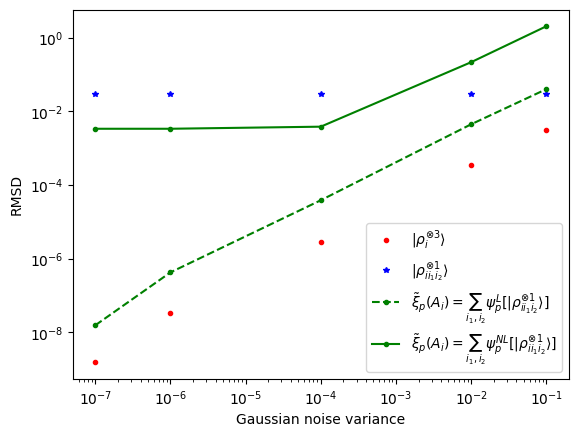

In [31]:
plt.loglog(variance, rmsd_rho3, 'r', ls="", marker="o", markersize=3, label =r"$|\rho_i^{\otimes{3}}\rangle$" )
plt.loglog(variance, rmsd_3c, 'b', ls="", marker="*", markersize=4, label = r"$|\rho_{ii_1 i_2}^{\otimes{1}}\rangle$")
plt.loglog(variance, lin_rmsd_encoded, 'g.', ls = '--', label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p^L[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$")
plt.loglog(variance, nl_rmsd_encoded, 'g.', ls = '-', label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p^{NL}[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$")
plt.xlabel("Gaussian noise variance")
plt.ylabel("RMSD")
plt.legend()
# plt.title("Linear encoder")



In [80]:
rmsd_encoded

[array(3.39651538e-08),
 array(2.71543144e-07),
 array(2.65478386e-05),
 array(0.00291955),
 array(0.02509275),
 array(0.24027632)]

# SUBMISSION 

In [172]:
def get_mean_error(predictions, target):
    first = (predictions[::2] + predictions[1::2]).flatten() / 2.0
    second = (target[::2] + target[1::2]).flatten() / 2.0
    values = first - second
    error = np.sqrt(np.mean(values ** 2))
    return error 

def get_delta_error(predictions, target):
    first = (predictions[::2]-predictions[1::2]).flatten()
    second = (target[::2]-target[1::2]).flatten()
    values = first - second
    error = np.sqrt(np.mean( values ** 2 ))   
    return error

def get_all_errors(predictions_train, predictions_val, target_train, target_val, relative=True):
#     target_full = np.concatenate([target_train, target_val], axis = 0)
    print("target_train.shape", target_train.shape)
    print("target_val.shape", target_val.shape)
    mean_error_train = get_mean_error(predictions_train, target_train)
    mean_error_val = get_mean_error(predictions_val, target_val)
    delta_error_train = get_delta_error(predictions_train, target_train)
    delta_error_val = get_delta_error(predictions_val, target_val)
#     normalization_mean = np.std(target_full)
    normalization_mean_train = np.std(target_train)
    normalization_mean_val = np.std(target_val)
    norm_delta_train = np.std(target_train[::2] - target_train[1::2])
    norm_delta_val = np.std(target_val[::2] - target_val[1::2])
#     normalization_delta = np.std(target_full[::2]-target_full[1::2])
    if relative:
        print("normalized")
#         print("mean_train", normalization_mean_train)
#         print("mean_test", normalization_mean_val)
#         print("delta_train", norm_delta_train)
#         print("delta_test", norm_delta_val)
        mean_error_train = mean_error_train / normalization_mean_train#normalization_mean
        mean_error_val = mean_error_val / normalization_mean_val#normalization_mean
        delta_error_train = delta_error_train / norm_delta_train#normalization_delta
        delta_error_val = delta_error_val / norm_delta_val#normalization_delta 
        
    return mean_error_train, mean_error_val, delta_error_train, delta_error_val



In [175]:
# from ase.visualize import view 
# frames = read('bispectrum_counter/boron/boron_8000_pbeccpvdz.xyz', ':8000')
from ase.io import write

In [176]:
# write('frame-354.xyz', frames[354])
# write('frame-355.xyz', frames[355])

# BORON

## Features

In [ ]:
feats_nu_to7 = hickle.load('bispectrum_counter/boron/feat_1234567_PCA.hickle')
output_size = feats_nu_to7.shape[-1]
target = feats_nu_to7[:,:output_size]
ntrain = 7000

### linear 

In [ ]:
pred_lin = np.load('bispectrum_counter/boron/pred_feat/silu_lin8k.npy')

In [56]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], feats_nu_to7[:7000], feats_nu_to7[7000:])
print("mean train error: ",lin_mean_train )
print("mean test error: ",lin_mean_val )
print("delta train error: ",lin_delta_train )
print("delta val train error: ",lin_delta_val )


target_train.shape (7000, 8000)
target_val.shape (1000, 8000)
normalized
mean train error:  0.009852770000171917
mean test error:  0.017416600517321922
delta train error:  1.0000000010279626
delta val train error:  1.0000000031103427


0.011056593343501751 1.0000536525794215


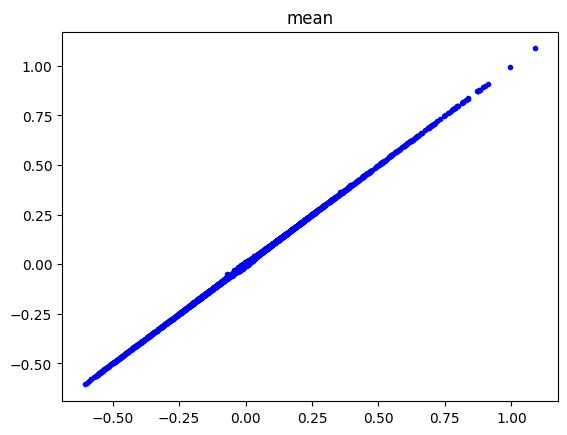

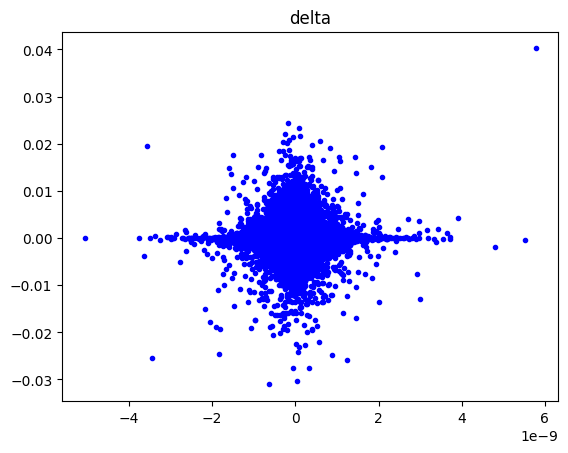

In [19]:
plt.plot((pred_lin[::2]+pred_lin[1::2])[ntrain//2:]/2, (target[::2]+target[1::2])[ntrain//2:]/2,'b.')
plt.title("mean")
plt.figure()
plt.plot((pred_lin[::2]-pred_lin[1::2])[ntrain//2:], (target[::2]-target[1::2])[ntrain//2:],'b.')
plt.title('delta')
print( 
    np.sqrt(np.mean( ((pred_lin[::2]+pred_lin[1::2]).flatten()[ntrain//2:]/2-(target[::2]+target[1::2]).flatten()[ntrain//2:]/2)**2 )) /np.std(target)
    ,
    np.sqrt(np.mean( ((pred_lin[::2]-pred_lin[1::2]).flatten()[ntrain//2:]-(target[::2]-target[1::2]).flatten()[ntrain//2:])**2 )) /np.std(target[::2]-target[1::2])     
     )

### non-linear

In [3]:
pred_nl = np.load('bispectrum_counter/boron/pred_feat/silu_nl8k.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'bisp/pred_feat/silu_nl8k.npy'

In [23]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], feats_nu_to7[:7000], feats_nu_to7[7000:])

print("mean train error: ",nl_mean_train )
print("mean test error: ",nl_mean_val )
print("delta train error: ",nl_delta_train )
print("delta val train error: ",nl_delta_val )

target_train.shape (7000, 8000)
target_val.shape (1000, 8000)
mean train error:  0.004352581283773807
mean test error:  0.006698606461081356
delta train error:  0.125429454333545
delta val train error:  0.14332104851049665


0.004700671671458836 0.12762845331134298


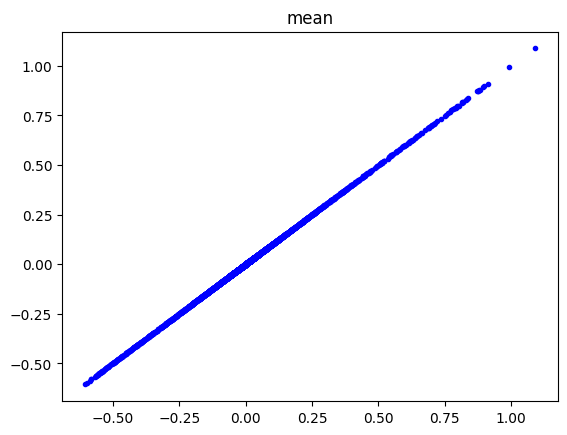

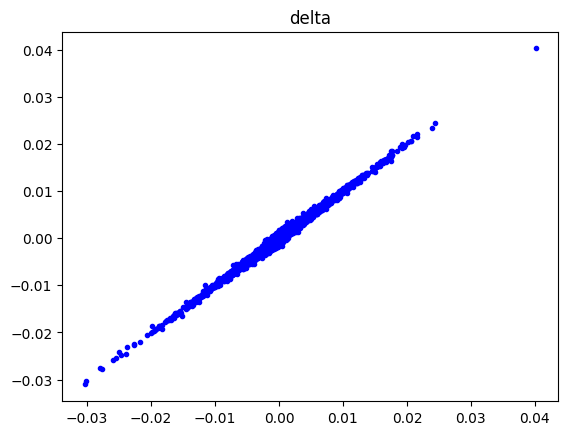

In [20]:
plt.plot((pred_nl[::2]+pred_nl[1::2])[ntrain//2:]/2, (target[::2]+target[1::2])[ntrain//2:]/2,'b.')
plt.title("mean")
plt.figure()
plt.plot((pred_nl[::2]-pred_nl[1::2])[ntrain//2:], (target[::2]-target[1::2])[ntrain//2:],'b.')
plt.title('delta')
print( 
    np.sqrt(np.mean( ((pred_nl[::2]+pred_nl[1::2]).flatten()[ntrain//2:]/2-(target[::2]+target[1::2]).flatten()[ntrain//2:]/2)**2 )) /np.std(target)
    ,
    np.sqrt(np.mean( ((pred_nl[::2]-pred_nl[1::2]).flatten()[ntrain//2:]-(target[::2]-target[1::2]).flatten()[ntrain//2:])**2 )) /np.std(target[::2]-target[1::2])     
     )

## Intermediate Energies

In [177]:
e0 = -198.27291671238572
from ase.io import read
import ast 
frames = read('bispectrum_counter/boron/boron_8000_pbeccpvdz.xyz', ':8000')
for fi, f in enumerate(frames):
    f.info["energy_rel"] = (f.info["energy_ha"]-e0)#*Hartree
    for n, v in zip( ("index", "label","r", "z_1", "z_2", "psi", "phi_1", "phi_2"), ast.literal_eval(f.info["pars"]) ):
        f.info[n] = v 
    if fi%2 ==1:
        frames[fi].info["delta"] = np.abs(frames[fi].info["energy_rel"]-frames[fi-1].info["energy_rel"])
        frames[fi-1].info["delta"] = frames[fi].info["delta"]
energy = np.asarray([f.info["energy_rel"] for f in frames])

### from lin, lin decoder

In [178]:
pred_fromlinlin = np.load('bispectrum_counter/boron/pred_feat/energy/linlin_encoded_energy.npy')

In [179]:
fromlinlin_mean_train, fromlinlin_mean_val, fromlinlin_delta_train, fromlinlin_delta_val = get_all_errors(pred_fromlinlin[:7000], pred_fromlinlin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromlinlin_mean_train )
print("mean test error: ",fromlinlin_mean_val )
print("delta train error: ",fromlinlin_delta_train )
print("delta val train error: ",fromlinlin_delta_val )

target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.4102880759959699
mean test error:  0.39092258408261604
delta train error:  1.0000023733357435
delta val train error:  1.0001233914499326


In [180]:
fromlinlin_mean_train, fromlinlin_mean_val, fromlinlin_delta_train, fromlinlin_delta_val = get_all_errors(pred_fromlinlin[:7000], pred_fromlinlin[7000:], energy[:7000], energy[7000:],relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",fromlinlin_mean_train*Hartree)
print("mean test error: ",fromlinlin_mean_val*Hartree )
print("delta train error: ",fromlinlin_delta_train*Hartree )
print("delta val train error: ",fromlinlin_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.5759592795062207
mean test error:  1.667459562567401
delta train error:  0.2501269133409327
delta val train error:  0.24509101376412618


### lin encoder, non linear decoder

In [181]:
pred_fromlin = np.load('bispectrum_counter/boron/pred_feat/energy/lin_encoded_energy.npy')

In [182]:
fromlin_mean_train, fromlin_mean_val, fromlin_delta_train, fromlin_delta_val = get_all_errors(pred_fromlin[:7000], pred_fromlin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromlin_mean_train )
print("mean test error: ",fromlin_mean_val )
print("delta train error: ",fromlin_delta_train )
print("delta val train error: ",fromlin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.028345945048963726
mean test error:  0.1726140448410326
delta train error:  1.0000023680757848
delta val train error:  1.0001234075849286


In [183]:
fromlin_mean_train, fromlin_mean_val, fromlin_delta_train, fromlin_delta_val = get_all_errors(pred_fromlin[:7000], pred_fromlin[7000:], energy[:7000], energy[7000:],relative=False)

print("ABSOLUTE in eV")
print("mean train error: ",fromlin_mean_train*Hartree)
print("mean test error: ",fromlin_mean_val*Hartree )
print("delta train error: ",fromlin_delta_train*Hartree )
print("delta val train error: ",fromlin_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.10887973048655353
mean test error:  0.7362760593099674
delta train error:  0.2501269120252786
delta val train error:  0.24509101771818081


### from nl 

In [184]:
pred_fromnl = np.load('bispectrum_counter/boron/pred_feat/energy/nl_encoded_energy.npy')

In [185]:
fromnl_mean_train, fromnl_mean_val, fromnl_delta_train, fromnl_delta_val = get_all_errors(pred_fromnl[:7000], pred_fromnl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromnl_mean_train )
print("mean test error: ",fromnl_mean_val )
print("delta train error: ",fromnl_delta_train )
print("delta val train error: ",fromnl_delta_val )

target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.0015317472814490897
mean test error:  0.11033838259912912
delta train error:  0.048115292051536425
delta val train error:  0.45723273101822215


In [186]:
fromnl_mean_train, fromnl_mean_val, fromnl_delta_train, fromnl_delta_val = get_all_errors(pred_fromnl[:7000], pred_fromnl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",fromnl_mean_train *Hartree)
print("mean test error: ",fromnl_mean_val*Hartree )
print("delta train error: ",fromnl_delta_train*Hartree )
print("delta val train error: ",fromnl_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.005883601019108903
mean test error:  0.4706425227769797
delta train error:  0.012034900922487789
delta val train error:  0.11204980758317373


## Energies 

### lin

In [187]:
pred_lin = np.load('bispectrum_counter/boron/pred_energy/batchmc2_lin_triple_energy_LBFGS.npy')

In [188]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",lin_mean_train )
print("mean test error: ",lin_mean_val )
print("delta train error: ",lin_delta_train )
print("delta val train error: ",lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.41694461033341307
mean test error:  0.38510917844709885
delta train error:  1.0000023738252333
delta val train error:  1.0001233879584155


In [189]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",lin_mean_train *Hartree)
print("mean test error: ",lin_mean_val*Hartree )
print("delta train error: ",lin_delta_train*Hartree )
print("delta val train error: ",lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.6015277219548099
mean test error:  1.6426627889535803
delta train error:  0.2501269134633669
delta val train error:  0.24509101290849228


### nl

In [190]:
pred_nl = np.load('bispectrum_counter/boron/pred_energy/batchmc2_nl_triple_energy.npy')

In [191]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nl_mean_train )
print("mean test error: ",nl_mean_val )
print("delta train error: ",nl_delta_train )
print("delta val train error: ",nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.005046620069444155
mean test error:  0.01769675861276713
delta train error:  0.10702010166137249
delta val train error:  0.19968327419839013


In [192]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nl_mean_train*Hartree )
print("mean test error: ",nl_mean_val*Hartree )
print("delta train error: ",nl_delta_train*Hartree )
print("delta val train error: ",nl_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.01938459388388603
mean test error:  0.07548458589199677
delta train error:  0.026768544163249256
delta val train error:  0.04893453800142764


### nu7 lin

In [193]:
pred_nu7lin = np.load('bispectrum_counter/boron/pred_energy/nu7_lin_single_energy.npy')

In [194]:
nu7lin_mean_train, nu7lin_mean_val, nu7lin_delta_train, nu7lin_delta_val = get_all_errors(pred_nu7lin[:7000], pred_nu7lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7lin_mean_train )
print("mean test error: ",nu7lin_mean_val )
print("delta train error: ",nu7lin_delta_train )
print("delta val train error: ",nu7lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.0740768270424306
mean test error:  0.12722941060106222
delta train error:  0.5504812065564629
delta val train error:  0.8875893087214347


In [195]:
nu7lin_mean_train, nu7lin_mean_val, nu7lin_delta_train, nu7lin_delta_val = get_all_errors(pred_nu7lin[:7000], pred_nu7lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu7lin_mean_train *Hartree)
print("mean test error: ",nu7lin_mean_val *Hartree)
print("delta train error: ",nu7lin_delta_train *Hartree)
print("delta val train error: ",nu7lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.28453681645635387
mean test error:  0.5426903074541237
delta train error:  0.1376898382639458
delta val train error:  0.21751332419628416


### nu7 nl 

In [196]:
pred_nu7nl = np.load('bispectrum_counter/boron/pred_energy/nu7_nl_single_energy.npy')

In [197]:
nu7nl_mean_train, nu7nl_mean_val, nu7nl_delta_train, nu7nl_delta_val = get_all_errors(pred_nu7nl[:7000], pred_nu7nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7nl_mean_train )
print("mean test error: ",nu7nl_mean_val )
print("delta train error: ",nu7nl_delta_train )
print("delta val train error: ",nu7nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.045195934344062376
mean test error:  0.10036617514867005
delta train error:  0.21180563558062157
delta val train error:  0.431465478175408


In [198]:
nu7nl_mean_train, nu7nl_mean_val, nu7nl_delta_train, nu7nl_delta_val = get_all_errors(pred_nu7nl[:7000], pred_nu7nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu7nl_mean_train*Hartree )
print("mean test error: ",nu7nl_mean_val*Hartree )
print("delta train error: ",nu7nl_delta_train *Hartree)
print("delta val train error: ",nu7nl_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.17360229627092216
mean test error:  0.4281066004480213
delta train error:  0.05297816412102476
delta val train error:  0.1057352646226234


### nu7 lin lbfgs

In [199]:
pred_nu7lin_lbfgs = np.load('bisp/pred_energy/nu7_lin_single_energy_LBFGS.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'bisp/pred_energy/nu7_lin_single_energy_LBFGS.npy'

In [50]:
nu7lin_lbfgs_mean_train, nu7lin_lbfgs_mean_val, nu7lin_lbfgs_delta_train, nu7lin_lbfgs_delta_val = get_all_errors(pred_nu7lin_lbfgs[:7000], pred_nu7lin_lbfgs[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7lin_lbfgs_mean_train )
print("mean test error: ",nu7lin_lbfgs_mean_val )
print("delta train error: ",nu7lin_lbfgs_delta_train )
print("delta val train error: ",nu7lin_lbfgs_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.08903491931752884
mean test error:  0.1373534014579147
delta train error:  0.904477867149621
delta val train error:  1.349707934825516


### nu3 nl

In [200]:
pred_nu3nl = np.load('bispectrum_counter/boron/pred_energy/nu3_nl_single_energy.npy')

In [201]:
nu3nl_mean_train, nu3nl_mean_val, nu3nl_delta_train, nu3nl_delta_val = get_all_errors(pred_nu3nl[:7000], pred_nu3nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu3nl_mean_train )
print("mean test error: ",nu3nl_mean_val )
print("delta train error: ",nu3nl_delta_train )
print("delta val train error: ",nu3nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.03682488236125799
mean test error:  0.1686216609441584
delta train error:  1.000002365376443
delta val train error:  1.0001233624553367


In [202]:
nu3nl_mean_train, nu3nl_mean_val, nu3nl_delta_train, nu3nl_delta_val = get_all_errors(pred_nu3nl[:7000], pred_nu3nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu3nl_mean_train*Hartree )
print("mean test error: ",nu3nl_mean_val*Hartree )
print("delta train error: ",nu3nl_delta_train*Hartree )
print("delta val train error: ",nu3nl_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.141448212778476
mean test error:  0.7192467574037975
delta train error:  0.2501269113501021
delta val train error:  0.24509100665868805


## nu3 lin

In [203]:
pred_nu3lin = np.load('bispectrum_counter/boron/pred_energy/nu3_lin_single_energy.npy')

In [204]:
nu3lin_mean_train, nu3lin_mean_val, nu3lin_delta_train, nu3lin_delta_val = get_all_errors(pred_nu3lin[:7000], pred_nu3lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu3lin_mean_train )
print("mean test error: ",nu3lin_mean_val )
print("delta train error: ",nu3lin_delta_train )
print("delta val train error: ",nu3lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.4103645475787769
mean test error:  0.3890968069999996
delta train error:  1.0000023738550745
delta val train error:  1.0001233851570352


In [205]:
nu3lin_mean_train, nu3lin_mean_val, nu3lin_delta_train, nu3lin_delta_val = get_all_errors(pred_nu3lin[:7000], pred_nu3lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu3lin_mean_train*Hartree )
print("mean test error: ",nu3lin_mean_val*Hartree )
print("delta train error: ",nu3lin_delta_train*Hartree )
print("delta val train error: ",nu3lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.5762530148292633
mean test error:  1.6596718071920764
delta train error:  0.25012691347083105
delta val train error:  0.2450910122219839


In [206]:
ypred_n3 = pred_nu3nl
ypred = pred_nl #pred_fromnl

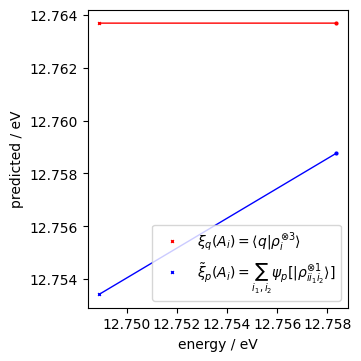

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5), constrained_layout=True)

ax.plot(np.hstack([energy[0:2:2],energy[1:2:2]])*Hartree, np.vstack([ypred_n3[:2:2],ypred_n3[1:2:2]])*Hartree,'r-', lw=1);
ax.plot(energy[0:2:2]*Hartree,ypred_n3[0:2:2]*Hartree,'r',ls="",marker='x',markersize=2, label=r"$\xi_q(A_i)=\langle q|\rho_i^{\otimes{3}}\rangle$");
ax.plot(energy[1:2:2]*Hartree,ypred_n3[1:2:2]*Hartree,'r',ls="",marker='o',markersize=2);

ax.plot(np.hstack([energy[:2:2],energy[1:2:2]])*Hartree, np.vstack([ypred[:2:2],ypred[1:2:2]])*Hartree,'b-', lw=1);
ax.plot(energy[0:2:2]*Hartree,ypred[0:2:2]*Hartree,'b',ls="",marker='x',markersize=2, label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$");
ax.plot(energy[1:2:2]*Hartree,ypred[1:2:2]*Hartree,'b',ls="",marker='o',markersize=2);

# ax.set_xlim(6,12)
# ax.set_ylim(6,12)
ax.set_xlabel('energy / eV')
ax.set_ylabel('predicted / eV')
ax.legend()

In [208]:
energy.shape

(8000,)

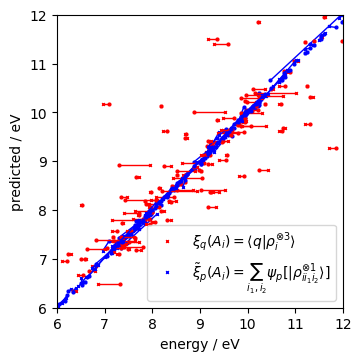

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5), constrained_layout=True)

for i in range(7000,7500,2):
    ax.plot(np.hstack([energy[i:i+2:2],energy[i+1:i+2:2]])*Hartree, np.vstack([ypred_n3[i+1:i+2:2],ypred_n3[i+1:i+2:2]])*Hartree,'r-', lw=1);
    ax.plot(energy[i:i+2:2]*Hartree,ypred_n3[i:i+2:2]*Hartree,'r',ls="",marker='x',markersize=2);
    ax.plot(energy[i+1:i+2:2]*Hartree,ypred_n3[i+1:i+2:2]*Hartree,'r',ls="",marker='o',markersize=2);

    ax.plot(np.hstack([energy[i:i+2:2],energy[i+1:i+2:2]])*Hartree, np.vstack([ypred[i:i+2:2],ypred[i+1:i+2:2]])*Hartree,'b-', lw=1);
    ax.plot(energy[i:i+2:2]*Hartree,ypred[i:i+2:2]*Hartree,'b',ls="",marker='x',markersize=2);
    ax.plot(energy[i+1:i+2:2]*Hartree,ypred[i+1:i+2:2]*Hartree,'b',ls="",marker='o',markersize=2);

ax.plot(energy[i:i+2:2]*Hartree,ypred_n3[i:i+2:2]*Hartree,'r',ls="",marker='x',markersize=2, label=r"$\xi_q(A_i)=\langle q|\rho_i^{\otimes{3}}\rangle$");
ax.plot(energy[i+1:i+2:2]*Hartree,ypred_n3[i+1:i+2:2]*Hartree,'r',ls="",marker='o',markersize=2);

ax.plot(np.hstack([energy[i:i+2:2],energy[i+1:i+2:2]])*Hartree, np.vstack([ypred[i:i+2:2],ypred[i+1:i+2:2]])*Hartree,'b-', lw=1);
ax.plot(energy[i:i+2:2]*Hartree,ypred[i:i+2:2]*Hartree,'b',ls="",marker='x',markersize=2, label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$");

ax.set_xlim(6,12)
ax.set_ylim(6,12)
ax.set_xlabel('energy / eV')
ax.set_ylabel('predicted / eV')

ax.legend()
fig.savefig("boron-energies.pdf")

# CARBON

In [34]:
ev_tokcalmol  = 23.0609

## train 8k cosmosrv

In [2]:
# import torch
# torch.set_default_dtype(torch.float64)
# torch.device= "cpu"
# device = "cpu"

In [36]:
np.std(energy_perat)*ev_tokcalmol

10.703690117881862

In [144]:
from ase.io import read
frames = read('/Users/jigyasa/scratch/bispectrum_counter/carbon/C_concatenated.xyz', ':')
energy_tot = np.array([f.info["energy"] for f in frames])
nat = np.array([len(f) for f in frames])
energy_perat = energy_tot/nat
ebase = frames[0].info['energy']/len(frames[0])
y = []
for f in frames:
    y.append(f.info['energy'] - ebase*len(f))
    f.info['energy_rel'] = y[-1]

energy = np.array([f.info["energy_rel"] for f in frames])
print(np.min(energy), np.max(energy))

-20.697736000000077 31.854233999999906


In [145]:
def mse_loss(pred, target):
    return np.sum((pred.flatten() - target.flatten()) ** 2)

def get_all(pred, target, ntrain, relative=False): 
    print("target min,max", target.min(),target.max() )
    ntest =len(target)-ntrain
    print("ntrain", ntrain, "ntest", ntest)
    train = np.sqrt(mse_loss(pred[:ntrain], target[:ntrain])/ntrain)
    test = np.sqrt(mse_loss(pred[ntrain:], target[ntrain:])/ntest)
    if relative: 
        train = train/np.std(target[:ntrain])
        test= test/np.std(target[ntrain:])
    return train, test

In [146]:
NTRAIN = 8000

In [147]:
pred_3c = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_triple_p0-nl.npy')
pred_3c_diff = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_triple_p0-nl-DIFF.npy')
pred_nu3 = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_single-NU3_asym-nl.npy')
pred_nu3_diff = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_single-NU3_asym-nl-DIFF.npy')
pred_nu2 = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/linearnu2-pred.npy')


In [148]:
pred_nu2 = pred_nu2.flatten()
energy_baselined = energy.copy().flatten()
energy_baselined = energy_baselined- pred_nu2
# energy_baselined = torch.tensor(energy)
print("baselined", energy.shape, np.min(energy_baselined), np.max(energy_baselined))

baselined (10000,) -9.179295461407596 7.51621137515386


In [149]:
get_all(pred_3c_diff, energy_baselined,NTRAIN)

target min,max -9.179295461407596 7.51621137515386
ntrain 8000 ntest 2000


(0.3920188434898392, 0.7255178848725554)

In [150]:
get_all(pred_nu3_diff, energy_baselined,NTRAIN)

target min,max -9.179295461407596 7.51621137515386
ntrain 8000 ntest 2000


(0.47096567089872415, 0.7535950057724944)

In [152]:
get_all(pred_3c_diff.flatten()+pred_nu2, energy,NTRAIN, relative=True)

target min,max -20.697736000000077 31.854233999999906
ntrain 8000 ntest 2000


(0.07464115901331385, 0.11895647990381514)

In [153]:
get_all(pred_nu3_diff.flatten()+pred_nu2, energy,NTRAIN, relative=True)

target min,max -20.697736000000077 31.854233999999906
ntrain 8000 ntest 2000


(0.08967279026288658, 0.12356002660849394)

In [160]:
aa = pred_3c_diff.flatten()+pred_nu2 
aa = np.array([aa[i]+ ebase*len(f) for i,f in enumerate(frames)])
print( get_all(aa, energy_tot,NTRAIN))
train, test = get_all(aa/nat, energy_tot/nat,NTRAIN)
print(train*ev_tokcalmol, test*ev_tokcalmol)

target min,max -3709.18372 -603.679469
ntrain 8000 ntest 2000
(0.3920188434898408, 0.7255178848725523)
target min,max -154.55650375 -150.91986725
ntrain 8000 ntest 2000
0.8155932626753943 0.8851750003480492


In [161]:
aa = pred_nu3_diff.flatten()+pred_nu2 
aa = np.array([aa[i]+ ebase*len(f) for i,f in enumerate(frames)])
print( get_all(aa, energy_tot,NTRAIN))
train, test =get_all(aa/nat, energy_tot/nat,NTRAIN)
print(train*ev_tokcalmol, test*ev_tokcalmol)

target min,max -3709.18372 -603.679469
ntrain 8000 ntest 2000
(0.47096567089872327, 0.7535950057724893)
target min,max -154.55650375 -150.91986725
ntrain 8000 ntest 2000
0.9658643835740262 0.9285587366769609


In [132]:
aa = pred_nu3_diff.flatten()+pred_nu2 
# aa = np.array([aa[i]+ ebase*len(f) for i,f in enumerate(frames)])

bb = pred_3c_diff.flatten()+pred_nu2 
# bb = np.array([bb[i]+ ebase*len(f) for i,f in enumerate(frames)])

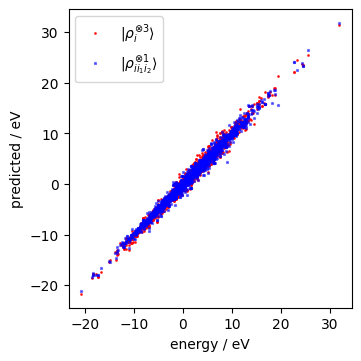

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5), constrained_layout=True)


ax.plot(energy[ntrain:], aa[ntrain:], 'r.',markersize=2,alpha = 0.8, label=r"$|\rho_i^{\otimes{3}}\rangle$" )
ax.plot(energy[ntrain:], bb[ntrain:], 'b*',markersize=2,alpha = 0.5,label=r"$|\rho_{ii_1 i_2}^{\otimes{1}}\rangle$")
ax.set_xlabel('energy / eV')
ax.set_ylabel('predicted / eV')

ax.legend()
fig.savefig("carbon-energies.pdf")

## log files on cosmopc

In [132]:
log_3nl = '/home/nigam/scratch/MAC/bispectrum_counter/carbon/train8k/fit_n4l3/log_nl_mc2batch'

In [159]:
epochs_3c = []
train_err_3c = []
val_err_3c = []
with open(log_3nl, 'r') as fp:
    for i, line in enumerate(fp):
#         print(i,line)
        if i>=19:
            line =line.split()
#             print(len(line),line)
            epoch, train, test = line[1], line[4], line[7]
            epochs_3c.append(int(epoch))
            train_err_3c.append(float(train))
            val_err_3c.append(float(test))
#             print(line[1], line[4], line[7])

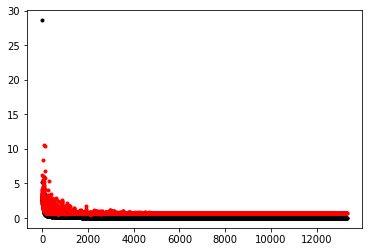

In [160]:
plt.plot(epochs_3c, train_err_3c, 'k.')
plt.plot(epochs_3c, val_err_3c, 'r.')

In [170]:
log_nu3 = '/home/nigam/scratch/MAC/bispectrum_counter/carbon/train8k/fit_n4l3/log_nu3_nl'

In [201]:
epochs_nu3 = []
train_err_nu3 = []
val_err_nu3 = []
with open(log_nu3, 'r') as fp:
    for i, line in enumerate(fp):

        if i>=29 and line.split()[0]=="epoch:":
            line =line.split()
#             print(i, len(line),line)
            epoch, train, test = line[1], line[4], line[7]
            epochs_nu3.append(int(epoch))
            train_err_nu3.append(float(train))
            val_err_nu3.append(float(test))
            
#             print(line[1], line[4], line[7])

In [202]:
len(epochs_nu3)

91575

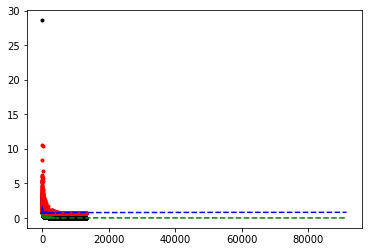

In [204]:
plt.plot(epochs_3c, train_err_3c, 'k.')
plt.plot(epochs_3c, val_err_3c, 'r.')

plt.plot(epochs_nu3, train_err_nu3, 'g--')
plt.plot(epochs_nu3, val_err_nu3, 'b--')

In [205]:
min(val_err_nu3)

0.6566914572992681

In [206]:
min(val_err_3c)

0.6432118160903881

In [210]:
np.where(np.isclose(val_err_3c,0.64321181609))

(array([708]),)

In [211]:
val_err_3c[708]

0.6432118160903881

## train 4k imx

In [120]:
from ase.io import read
frames = read('/home/nigam/scratch/MAC/bispectrum_counter/carbon/C_lessthan14.xyz', ':')
energy_tot = np.array([f.info["energy"] for f in frames])
nat = np.array([len(f) for f in frames])
energy_perat = energy_tot/nat
ebase = frames[0].info['energy']/len(frames[0])
y = []
for f in frames:
    y.append(f.info['energy'] - ebase*len(f))
    f.info['energy_rel'] = y[-1]

energy = np.array([f.info["energy_rel"] for f in frames])
print(np.min(energy), np.max(energy))

-36.15852571428604 16.39344428571394


In [92]:
ev_tokcalmol  = 23.0609

In [93]:
ntrain = 4000

In [94]:
def mse_loss(pred, target, ntrain, relative=False):
    ntest = len(pred)-ntrain
    print(ntrain, ntest)
    mse_train = np.sqrt(np.sum((pred[:ntrain].flatten() - target[:ntrain].flatten()) ** 2)/ntrain)
    mse_test = np.sqrt(np.sum((pred[ntrain:].flatten() - target[ntrain:].flatten()) ** 2)/ntest)
    if not relative:
        return mse_train, mse_test
    else: 
        return mse_train/np.std(target[:ntrain]), mse_test/np.std(target[ntrain:])
        
        

## n4l3rcut4

### 3c

In [111]:
pred_3cnl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3/batchmc2_triple_p0-nl.npy')

In [113]:
pred_3cnl_tot = np.asarray([pred_3cnl[i]+ebase*len(f) for i,f in enumerate(frames)])

In [115]:
pred_3cnl_tot= pred_3cnl_tot.reshape(4415,)

In [107]:
pred_3cnl/nat#.shape

array([ 0.01108433,  0.669016  , -0.33404045, ...,  0.08118218,
        0.06765755, -0.02917977])

In [116]:
mse_loss(pred_3cnl_tot/nat, energy_perat, ntrain)

4000 415


(0.013924743206945589, 0.05371149836091454)

In [123]:
0.42*ev_tokcalmol

9.685578

In [110]:
pred_3cnl/nat

array([ 0.01108433,  0.669016  , -0.33404045, ...,  0.08118218,
        0.06765755, -0.02917977])

In [121]:
np.mean(nat)

14.423027404818834

In [118]:
mse_loss(pred_3cnl_tot, energy_tot, ntrain)

4000 415


(0.11048783206404543, 0.4204881063911966)

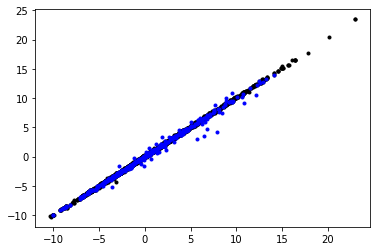

In [72]:
plt.plot(energy[:ntrain],pred_3cnl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_3cnl[ntrain:], 'b.')

In [73]:
mse_loss(pred_3cnl_tot, energy_tot, ntrain)
# mev_tokcalmol  

4000 415


(0.11048783206404543, 0.4204881063911966)

### nu3

In [32]:
pred_nu3nl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3/batchmc2_single-NU3_asym-nl.npy')

In [33]:
mse_loss(pred_nu3nl, energy, ntrain)

(0.10446067262314604, 0.3718448582007854)

In [34]:
pred_nu3nl_tot = np.asarray([pred_nu3nl[i]+ebase*len(f) for i,f in enumerate(frames)])

In [35]:
mse_loss(pred_nu3nl_tot, energy_tot, ntrain)

(0.10446067262314891, 0.37184485820078267)

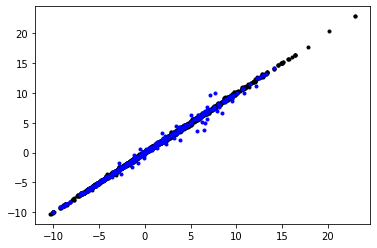

In [37]:
plt.plot(energy[:ntrain],pred_nu3nl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nl[ntrain:], 'b.')

### nu3 sum

In [45]:
pred_nu3nlsum = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3/batchmc2_single-NU3_asym-nl-SUM.npy')

In [46]:
mse_loss(pred_nu3nlsum, energy, ntrain)

(0.11579400908783584, 0.42626814864487306)

In [47]:
pred_nu3nlsum_tot = np.asarray([pred_nu3nlsum[i]+ebase*len(f) for i,f in enumerate(frames)])

In [48]:
mse_loss(pred_nu3nlsum_tot, energy_tot, ntrain)

(0.11579400908783721, 0.4262681486448721)

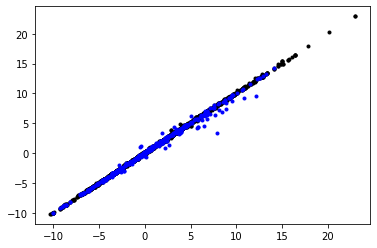

In [49]:
plt.plot(energy[:ntrain],pred_nu3nlsum[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nlsum[ntrain:], 'b.')

## n4l3rcut2.5

### 3c

In [38]:
pred_3cnl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3rcut2.5/batchmc2_triple_p0-nl.npy')

In [39]:
mse_loss(pred_3cnl, energy, ntrain)

(0.12855058399523922, 0.38007323422018136)

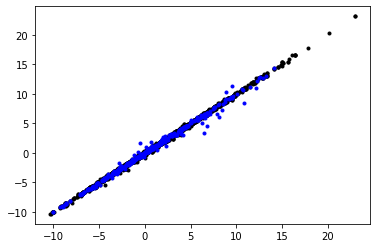

In [43]:
plt.plot(energy[:ntrain],pred_3cnl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_3cnl[ntrain:], 'b.')

### nu3

In [40]:
pred_nu3nl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3rcut2.5/batchmc2_single-NU3_asym-nl.npy')

In [41]:
mse_loss(pred_nu3nl, energy, ntrain)

(0.10417165859354321, 0.3355311912005077)

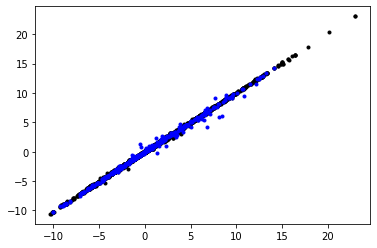

In [42]:
plt.plot(energy[:ntrain],pred_nu3nl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nl[ntrain:], 'b.')

### nu3 sum

In [50]:
pred_nu3nlsum = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3rcut2.5/batchmc2_single-NU3_asym-nl-SUM.npy')

In [51]:
mse_loss(pred_nu3nlsum, energy, ntrain)

(0.066614718064105, 0.4072195873845343)

In [52]:
pred_nu3nlsum_tot = np.asarray([pred_nu3nlsum[i]+ebase*len(f) for i,f in enumerate(frames)])

In [53]:
mse_loss(pred_nu3nlsum_tot, energy_tot, ntrain)

(0.06661471806410689, 0.40721958738453706)

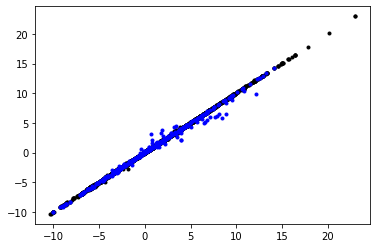

In [54]:
plt.plot(energy[:ntrain],pred_nu3nlsum[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nlsum[ntrain:], 'b.')

# CHECKS

In [ ]:
from ase.io import read, write
import hickle
from sklearn.decomposition import PCA 
import ase 
import json
from tqdm import tqdm
class tqdm_reusable:
    def __init__(self, *args, **kwargs):
        self._args = args
        self._kwargs = kwargs

    def __iter__(self):
        return tqdm(*self._args, **self._kwargs).__iter__()
import torch
import copy 
import numpy as np
import scipy as sp
from equistore.io import load,save
from equistore import Labels, TensorBlock, TensorMap
from itertools import product
from equistore_utils.clebsh_gordan import ClebschGordanReal
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion
from equistore import operations
import sys, os
sys.path.append(os.getcwd())
from feat_settings import *
cg = ClebschGordanReal(5)
from equistore_utils.mp_utils import *

import scipy
frames = read(frames_file, ":2")
print(len(frames))
#
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)
## selects only one environment
rho1i = operations.slice(rho1i, axis="samples", labels=Labels(['center'],np.array([[0]], np.int32)) )
# norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
# for b in rho1i.blocks():
#     b.values[:]/=norm_rho1
##print(np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean()))
#
calculator = PairExpansion(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, axis="samples", labels=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
norm_gij = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in gij.blocks()],axis=0).mean())
# for b in gij.blocks():
#     b.values[:]/=norm_gij

In [ ]:
test = operations.sum_over_samples(gij, sample_names=["neighbor"])
print("test (should be zero)", np.linalg.norm(rho1i.block(0).values/test.block(0).values -1))
#
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)


In [ ]:
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=lcut, other_keys_match=["species_center"])
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])

In [78]:
(np.linalg.norm(rho3i.block(0).values)**2+ np.linalg.norm(rho3i.block(1).values)**2)#/(norm_rho1**2)

0.9293165079625991

In [77]:
(np.linalg.norm(a.block(0).values)**2+np.linalg.norm(a.block(1).values)**2)#/(norm_gij**1)

1.0551691087322637